In [1]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from finance.utilities import utils
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

#### Analytics on model predictions

In [2]:
MODEL_ID = 's1'
SYMBOL = 'ASML'
query = f'''
    with
    raw_stocks as (
      select
          market_datetime
        , symbol
        , open
        , min(open) over (w rows between 1 following and 31 following) as thirty_day_low
        , abs(open - avg(open) over (w rows between 31 preceding and 1 preceding)) as deviation
      from td.stocks
      where market_datetime between '2020-01-01' and '2020-10-10'
      window w as (partition by symbol order by market_datetime)
    )
    , stocks as (
      select *
        , avg(deviation) over w / count(*) over w as mae
      from raw_stocks
      window w as (
        partition by symbol
        order by market_datetime
        rows between 31 preceding and 1 preceding
      )
    )
    , predictions as (
      select *
        , denormalized_prediction as thirty_day_low_prediction
        , row_number() over (partition by symbol order by market_datetime desc) as rn
      from dev.predictions
      where model_id = '{MODEL_ID}'
    )
    , base as (
     select
         p.model_id
       , s.market_datetime
       , s.symbol
       , s.open
       , s.thirty_day_low
       , p.thirty_day_low_prediction
       , s.thirty_day_low <= p.thirty_day_low_prediction as is_loss
       , (s.thirty_day_low - p.thirty_day_low_prediction) / p.thirty_day_low_prediction as net_win_loss
       , greatest((s.thirty_day_low - p.thirty_day_low_prediction) / p.thirty_day_low_prediction, 0) as loss
       , min(case when s.open <= p.thirty_day_low_prediction then s.market_datetime end) over (partition by s.symbol order by s.market_datetime rows between 1 following and 31 following) - s.market_datetime as n_days_to_loss
       , open - mae * 10 as benchmark_prediction
       --, .9 * open as benchmark_prediction
       , open - mae * 10 < thirty_day_low as benchmarket_is_profitable
     from stocks as s
     inner join predictions as p
       on  p.symbol = s.symbol
       and (p.market_datetime = s.market_datetime
         or (p.market_datetime < s.market_datetime and p.rn = 1)
       )
    )
    {{cte}}
    '''
cte = '''
    select *
    from base
    order by 1,2,3
    '''
df = utils.query_db(query=query.format(cte=cte))
df.head(10)

,model_id,market_datetime,symbol,open,thirty_day_low,thirty_day_low_prediction,is_loss,net_win_loss,loss,n_days_to_loss,benchmark_prediction,benchmarket_is_profitable
0,s1,2020-07-07,A,88.84,88.83,86.077255,False,0.031980,0.031980,NaN,87.272010,True
1,s1,2020-07-07,A,88.84,88.83,86.077255,False,0.031980,0.031980,43.0,87.272010,True
2,s1,2020-07-07,AA,11.23,10.49,8.224746,False,0.275419,0.275419,NaN,10.606634,False
3,s1,2020-07-07,AA,11.23,10.49,8.224746,False,0.275419,0.275419,NaN,10.606634,False
4,s1,2020-07-07,AAMC,17.32,12.55,13.975626,True,-0.102008,0.000000,NaN,16.860448,False
5,s1,2020-07-07,AAMC,17.32,12.55,13.975626,True,-0.102008,0.000000,NaN,16.860448,False
6,s1,2020-07-07,AAN,44.33,42.25,37.668409,False,0.121630,0.121630,NaN,42.047133,True
7,s1,2020-07-07,AAN,44.33,42.25,37.668409,False,0.121630,0.121630,NaN,42.047133,True
8,s1,2020-07-07,AAP,137.92,133.31,130.863290,False,0.018697,0.018697,NaN,134.483956,False
9,s1,2020-07-07,AAP,137.92,133.31,130.863290,False,0.018697,0.018697,NaN,134.483956,False


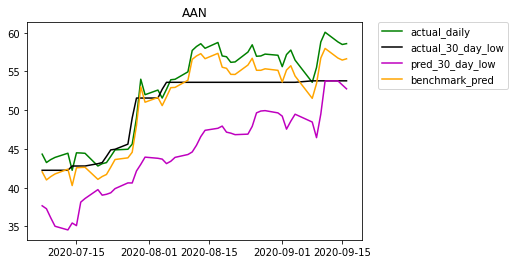

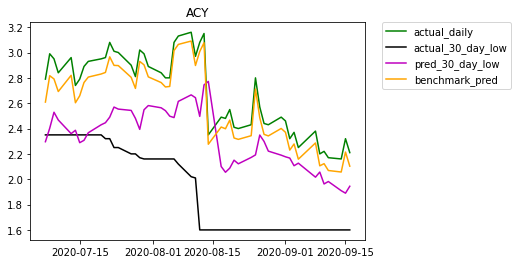

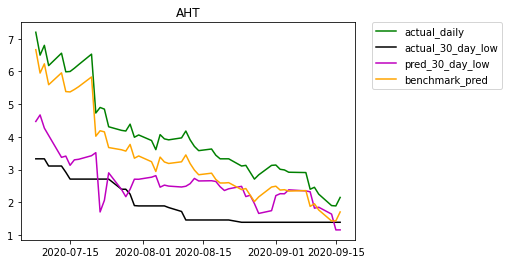

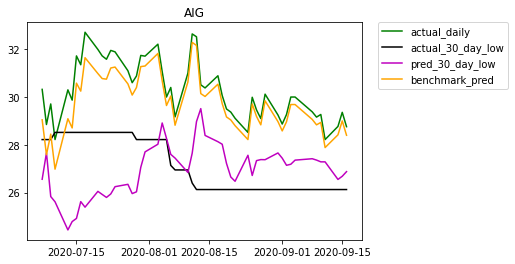

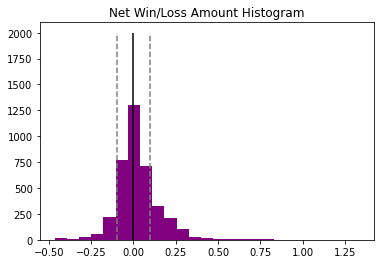

In [3]:
STOCKS = [
    'AAN',
    'ACY',
    'AHT',
    'AIG',
]

for s in STOCKS:
    x = df[df['symbol']==s]

    plt.title(s)
    plt.plot(x['market_datetime'], x['open'], color='g', label='actual_daily')
    plt.plot(x['market_datetime'], x['thirty_day_low'], color='black', label='actual_30_day_low')
    plt.plot(x['market_datetime'], x['thirty_day_low_prediction'], color='m', label='pred_30_day_low')
    plt.plot(x['market_datetime'], x['benchmark_prediction'], color='orange', label='benchmark_pred')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.show()

plt.title('Net Win/Loss Amount Histogram')
plt.hist(df.loc[df['net_win_loss'].notnull(), 'net_win_loss'], bins=25, color='purple')
plt.vlines(-.1, ymin=0, ymax=2000, color='grey', linestyles='dashed')
plt.vlines(0, ymin=0, ymax=2000, color='black')
plt.vlines(.1, ymin=0, ymax=2000, color='grey', linestyles='dashed')
plt.show()

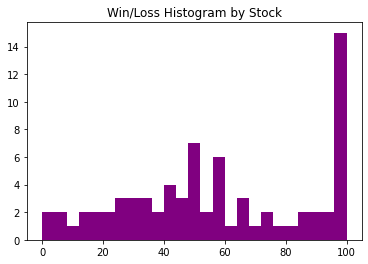

In [4]:
cte = '''
    select
        symbol
      , 100 * sum(case when is_loss then 0 else 1 end) / count(*) as win_rate
    from base
    group by 1
    '''
df = utils.query_db(query=query.format(cte=cte))
df.head(10)

plt.title('Win/Loss Histogram by Stock')
plt.hist(df['win_rate'], bins=25, color='purple')
plt.show()

In [5]:
cte = '''
    select
        market_datetime
      , 100 * sum(case when is_loss then 0 else 1 end) / count(*) as win_rate
      , max(loss) as largest_daily_loss
      , coalesce(avg(n_days_to_loss), 0) as avg_n_days_to_nearest_loss
    from base
    group by 1
    order by 1
    '''
df = utils.query_db(query=query.format(cte=cte))
df.head(10)

,market_datetime,win_rate,largest_daily_loss,avg_n_days_to_nearest_loss
0,2020-07-07,62,0.357487,11.674419
1,2020-07-08,64,0.340182,17.380952
2,2020-07-09,72,0.346309,17.142857
3,2020-07-10,82,0.333896,20.666667
4,2020-07-13,83,0.432075,19.888889
5,2020-07-14,83,0.526211,21.409091
6,2020-07-15,85,0.449765,22.291667
7,2020-07-16,83,0.306290,22.217391
8,2020-07-17,82,0.315738,21.521739
9,2020-07-20,77,0.429059,20.480000


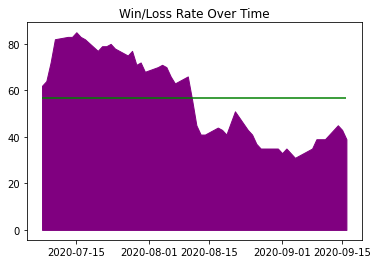

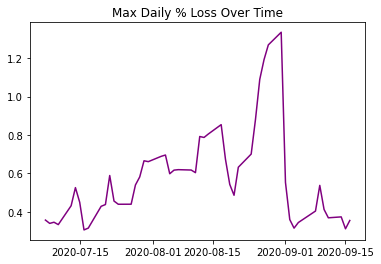

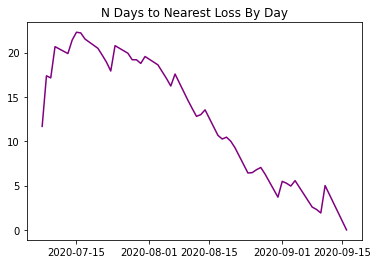

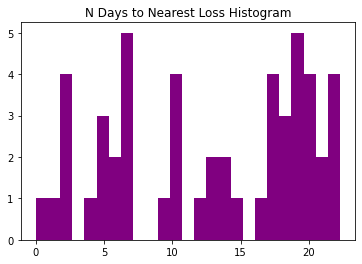

In [6]:
plt.title('Win/Loss Rate Over Time')
plt.fill_between(df['market_datetime'], df['win_rate'], color='purple')
plt.hlines(df['win_rate'].mean(), xmin=df['market_datetime'].min(), xmax=df['market_datetime'].max(), color='g')
plt.show()

plt.title('Max Daily % Loss Over Time')
plt.plot(df['market_datetime'], df['largest_daily_loss'], color='purple')
plt.show()

plt.title('N Days to Nearest Loss By Day')
plt.plot(df['market_datetime'], df['avg_n_days_to_nearest_loss'], color='purple')
plt.show()

plt.title('N Days to Nearest Loss Histogram')
plt.hist(df['avg_n_days_to_nearest_loss'], bins=25, color='purple')
plt.show()